# Адаптивные методы (20 баллов)

In [20]:
import os
from tqdm import tqdm
import numpy as np
import urllib.request
import zipfile
from IPython.display import Audio, display
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import torch
from torch.utils.data import DataLoader, random_split
from torch.optim.optimizer import Optimizer

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Основная часть (10 баллов)


__Задача 1.__ В данном задании мы рассмотрим применение глубоких нейронных сетей для задачи шумоподавления аудиосигналов на датасете [`VoiceBank-DEMAND`](https://huggingface.co/datasets/JacobLinCool/VoiceBank-DEMAND-16k). Скачать можно с [диска](https://disk.yandex.ru/d/r0XIWHFBSxbiUA), возможно так будет быстрее, чем через код. Поскольку обработка аудиоданных требует сохранения временной структуры и тонких спектральных характеристик, мы будем использовать архитектуры на основе спектральных преобразований и автоэнкодеров. В нашем случае мы рассмотрим семейство адаптивных методов, таким как `AdaGrad`, `RMSProp`, `Adam`, `AdamW` и `Muon`.

In [22]:
# Создание директории для данных
os.makedirs("data", exist_ok=True)

# Скачивание данных
urls = [
    "https://datashare.ed.ac.uk/bitstream/handle/10283/2791/clean_trainset_28spk_wav.zip",
    "https://datashare.ed.ac.uk/bitstream/handle/10283/2791/noisy_trainset_28spk_wav.zip",
    "https://datashare.ed.ac.uk/bitstream/handle/10283/2791/clean_testset_wav.zip",
    "https://datashare.ed.ac.uk/bitstream/handle/10283/2791/noisy_testset_wav.zip"
]

for url in urls:
    filename = url.split('/')[-1]
    dest_path = f"data/{filename}"

    if os.path.exists(dest_path):
        print(f"Файл {filename} уже существует.")
    else:
        print(f"Скачивание {filename}...")

        with tqdm(unit='B', unit_scale=True, unit_divisor=1024, desc=filename) as pbar:
            def reporthook(block_num, block_size, total_size):
                if total_size > 0:
                    pbar.total = total_size
                pbar.update(block_size)

            urllib.request.urlretrieve(url, dest_path, reporthook)

    print(f"Распаковка {filename}...")
    with zipfile.ZipFile(dest_path, 'r') as zip_ref:
        zip_ref.extractall("data")

    os.remove(dest_path)
    print(f"{filename} скачан и распакован.\n")

Скачивание clean_trainset_28spk_wav.zip...


clean_trainset_28spk_wav.zip: 2.32GB [04:22, 9.49MB/s]                            


Распаковка clean_trainset_28spk_wav.zip...
clean_trainset_28spk_wav.zip скачан и распакован.

Скачивание noisy_trainset_28spk_wav.zip...


noisy_trainset_28spk_wav.zip: 2.64GB [14:42, 3.21MB/s]                            


Распаковка noisy_trainset_28spk_wav.zip...
noisy_trainset_28spk_wav.zip скачан и распакован.

Скачивание clean_testset_wav.zip...


clean_testset_wav.zip: 147MB [00:18, 8.36MB/s]                           


Распаковка clean_testset_wav.zip...
clean_testset_wav.zip скачан и распакован.

Скачивание noisy_testset_wav.zip...


noisy_testset_wav.zip: 163MB [00:15, 11.2MB/s]                           


Распаковка noisy_testset_wav.zip...
noisy_testset_wav.zip скачан и распакован.



В файле `model.py` реализованы все необходимые компоненты для обучения модели:  
- Датасет (`VoiceBankDataset`) — загрузка и предобработка аудио;
- Архитектура (`UNetSpectrogramDenoiser`) — U-Net для обработки спектрограмм;  
- Метрики ([`SNR`](https://en.wikipedia.org/wiki/Signal-to-noise_ratio), [`SI-SDR`](https://arxiv.org/abs/1811.02508)) – оценка качества очищенного звука;
- Трейнер (`trainer`).

In [23]:
url = "https://raw.githubusercontent.com/BRAIn-Lab-teaching/OPTIMIZATION-METHODS-COURSE/%D0%9F%D0%9C%D0%98_%D0%BE%D1%81%D0%B5%D0%BD%D1%8C_2025/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B8%D0%B5%20%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D1%8F/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5%20%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5%2012/model.py"
!wget -O model.py "$url"

from model import VoiceBankDataset, UNetSpectrogramDenoiser, pad_and_crop_collate, trainer, extract_phase_and_chunk, istft_from_mag_phase

--2025-11-06 18:29:39--  https://raw.githubusercontent.com/BRAIn-Lab-teaching/OPTIMIZATION-METHODS-COURSE/%D0%9F%D0%9C%D0%98_%D0%BE%D1%81%D0%B5%D0%BD%D1%8C_2025/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B8%D0%B5%20%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D1%8F/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5%20%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5%2012/model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21955 (21K) [text/plain]
Saving to: ‘model.py’

model.py            100%[===================>]  21.44K  --.-KB/s    in 0s      

2025-11-06 18:29:39 (198 MB/s) - ‘model.py’ saved [21955/21955]



In [24]:
base = "./data"
train_noisy = os.path.join(base, "noisy_trainset_28spk_wav")
train_clean = os.path.join(base, "clean_trainset_28spk_wav")
test_noisy  = os.path.join(base, "noisy_testset_wav")
test_clean  = os.path.join(base, "clean_testset_wav")

full_train_ds = VoiceBankDataset(train_noisy, train_clean)
full_test_ds = VoiceBankDataset(test_noisy, test_clean)

train_ratio = 0.1
test_ratio = 0.1

# Разделяем датасеты
train_ds, _ = random_split(
    full_train_ds,
    [int(len(full_train_ds) * train_ratio), len(full_train_ds) - int(len(full_train_ds) * train_ratio)],
    generator=torch.Generator().manual_seed(420)
)

test_ds, _ = random_split(
    full_test_ds,
    [int(len(full_test_ds) * test_ratio), len(full_test_ds) - int(len(full_test_ds) * test_ratio)],
    generator=torch.Generator().manual_seed(420)
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4,
                          collate_fn=pad_and_crop_collate, drop_last=True
                         )
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=4,
                         collate_fn=pad_and_crop_collate, drop_last=False
                        )

print(f"Original train dataset size: {len(full_train_ds)}")
print(f"Original test dataset size: {len(full_test_ds)}")
print(f"Using train dataset size: {len(train_ds)}")
print(f"Using test dataset size: {len(test_ds)}")
print(f"Train batches per epoch: {len(train_loader)}")
print(f"Test batches per epoch: {len(test_loader)}")
nm, cm, nw, cw = next(iter(train_loader))
print("Noisy mag batch:", nm.shape)   # (B, 256, T_mag)
print("Noisy wav batch:", nw.shape)   # (B, T_wav)

Original train dataset size: 11572
Original test dataset size: 824
Using train dataset size: 1157
Using test dataset size: 82
Train batches per epoch: 72
Test batches per epoch: 6
Noisy mag batch: torch.Size([16, 256, 648])
Noisy wav batch: torch.Size([16, 229920])


__а) (1.5 балла)__ Перейдем к написанию оптимизационных методов. Реализуйте первый из адаптивных методов [`AdaGrad`](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adagrad.html).

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^0 \in \mathbb{R}^d$
- Начальный буфер $G_{-1} = 0 \in \mathbb{R}^d$
- Размер шага $\{ \gamma_k \}_{k=0} > 0$
- Коэффициент $L_2$-регуляризации $\lambda \geq 0$

---

$k$_-ая итерация_:

1. Добавить регуляризационный член к градиенту:

$$
g^k = \nabla f \left(x^k\right) + \lambda x
$$

2. Обновить сумму квадратов градиентов:

$$
G^k = G^{k - 1} + \left(g^k\right)^2
$$

3. Сделать шаг алгоритма:

$$
x^{k + 1} = x^k - \gamma_k \frac{g^k}{\sqrt{G^k + \varepsilon}} $$

In [25]:
class Adagrad(Optimizer):
    """
    Реализация оптимизатора Adagrad.

    Параметры:
        params (Iterable): Итерируемый объект параметров для оптимизации или словарь
        lr (float): Скорость обучения
        weight_decay (float): Коэффициент L2-регуляризации
    """

    def __init__(self, params, lr=1e-2, weight_decay=1e-2):
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super(Adagrad, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        """
        Выполняет один шаг оптимизатора.

        Параметры:
            closure (Сallable): Замыкание, которое пересчитывает модель и возвращает loss

        Возвращает:
            loss (float): Значение функции потерь
        """
        loss = closure() if closure is not None else None

        for group in self.param_groups:
            lr = group['lr']
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data
                if weight_decay != 0:
                    grad = grad.add(p.data, alpha=weight_decay)

                state = self.state[p]
                if 'sum' not in state:
                    state['sum'] = torch.zeros_like(p.data)

                state['sum'].addcmul_(grad, grad, value=1)

                std = state['sum'].sqrt().add(1e-10)
                p.data.addcdiv_(grad, std, value=-lr)

        return loss

Проверьте работу:

In [26]:
train_losses_adagrad, test_losses_adagrad, test_snr_adagrad, test_si_sdr_adagrad, model = trainer(
    num_epochs=1,
    batch_size=16,
    model_class=UNetSpectrogramDenoiser,
    criterion=torch.nn.MSELoss(),
    optimizer_class=Adagrad,
    optimizer_params={'lr': 1e-3, 'weight_decay': 1e-2},
    train_loader=train_loader,
    test_loader=test_loader,
    save_models=False,
    optimizer_name='Adagrad',
    test=True
)

Эпоха 1/1 | Время: 00:08 | Потери (обучение): 0.0120 | Потери (тест): 0.2020 | SNR: -0.10 дБ | SI-SDR: -2.62 дБ


__б) (1.5 балла)__ Теперь реализуем [`RMSProp`](https://docs.pytorch.org/docs/stable/generated/torch.optim.RMSprop.html). Основным отличием является, что теперь используется не сумма квадратов градиентов, а скользящая сумма.

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^0 \in \mathbb{R}^d$
- Начальный буфер $G_{-1} = 0 \in \mathbb{R}^d$
- Размер шага $\{ \gamma_k \}_{k=0} > 0$
- Коэффициент $L_2$-регуляризации $\lambda \geq 0$
- Коэффициент сглаживания квадратов градиентов $\beta \geq 0$

---

$k$_-ая итерация_:

1. Добавить регуляризационный член к градиенту:

$$
g^k = \nabla f \left(x^k\right) + \lambda x
$$

2. Обновить сумму квадратов градиентов:

$$
G^k = \beta G^{k - 1} + (1 - \beta) \left(g^k\right)^2
$$

3. Сделать шаг алгоритма:

$$
x^{k + 1} = x^k - \gamma_k \frac{g^k}{\sqrt{G^k + \varepsilon}} $$

In [27]:
class RMSprop(Optimizer):
    """
    Реализация оптимизатора RMSprop.

    Параметры:
        params (Iterable): Итерируемый объект параметров для оптимизации или словарь
        lr (float): Скорость обучения
        beta (float): Параметр сглаживания квадратов градиентов
        weight_decay (float): Коэффициент L2-регуляризации
    """

    def __init__(self, params, lr=1e-2, beta=0.99, weight_decay=1e-2):
        defaults = dict(lr=lr, beta=beta, weight_decay=weight_decay)
        super(RMSprop, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        """
        Выполняет один шаг оптимизатора.

        Параметры:
            closure (Сallable): Замыкание, которое пересчитывает модель и возвращает loss

        Возвращает:
            loss (float): Значение функции потерь
        """
        loss = closure() if closure is not None else None

        for group in self.param_groups:
            lr = group['lr']
            beta = group['beta']
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data
                if weight_decay != 0:
                    grad = grad.add(p.data, alpha=weight_decay)

                state = self.state[p]
                if 'sum' not in state:
                    state['sum'] = torch.zeros_like(p.data)

                state['sum'].mul_(beta).addcmul_(grad, grad, value=1 - beta)

                std = state['sum'].sqrt().add(1e-8)
                p.data.addcdiv_(grad, std, value=-lr)

        return loss

Проверьте работу:

In [28]:
train_losses_rmsprop, test_losses_rmsprop, test_snr_rmsprop, test_si_sdr_rmsprop, model = trainer(
    num_epochs=1,
    batch_size=16,
    model_class=UNetSpectrogramDenoiser,
    criterion=torch.nn.MSELoss(),
    optimizer_class=RMSprop,
    optimizer_params={'lr': 1e-3, 'weight_decay': 1e-2},
    train_loader=train_loader,
    test_loader=test_loader,
    save_models=False,
    optimizer_name='RMSprop',
    test=True
)

Эпоха 1/1 | Время: 00:07 | Потери (обучение): 0.0143 | Потери (тест): 0.1511 | SNR: 0.14 дБ | SI-SDR: -0.67 дБ


__в) (1.5 балла)__ Перейдем к самому популярному алгоритму оптимизации [`Adam`](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html). В нем добавляется еще один момент для обновления сглаженного среднего градиентов.

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^0 \in \mathbb{R}^d$
- Начальный буфер $v^{-1} = 0 \in \mathbb{R}^d$
- Начальный буфер $G_{-1} = 0 \in \mathbb{R}^d$
- Размер шага $\{ \gamma_k \}_{k=0} > 0$
- Коэффициент $L_2$-регуляризации $\lambda \geq 0$
- Коэффициент сглаживания градиентов $\beta_1 \geq 0$
- Коэффициент сглаживания квадратов градиентов $\beta_2 \geq 0$

---

$k$_-ая итерация_:

1. Добавить регуляризационный член к градиенту:

$$
g^k = \nabla f \left(x^k\right) + \lambda x
$$

2. Обновить сумму градиентов:

$$
v^k = \beta_1 v^{k - 1} + (1 - \beta_1) g^k
$$

3. Выполним поправку смещения:

$$
\hat{v}^k = \frac{v^k}{1 - \beta_1^{k + 1}}
$$

4. Обновить сумму квадратов градиентов:

$$
G^k = \beta_2 G^{k - 1} + (1 - \beta_2) \left(g^k\right)^2
$$

5. Выполнить поправку смещения

$$
\hat{G}^k = \frac{G^k}{1 - \beta_2^{k + 1}}
$$

5. Сделать шаг алгоритма:

$$
x^{k + 1} = x^k - \gamma_k \frac{\hat{v}^k}{\sqrt{\hat{G}^k + \varepsilon}}
$$

In [29]:
class Adam(Optimizer):
    """
    Реализация оптимизатора Adam.

    Параметры:
        params (Iterable): Итерируемый объект параметров для оптимизации или словарь
        lr (float): Скорость обучения
        betas (tuple): Параметры сглаживания
        weight_decay (float): Коэффициент L2-регуляризации
    """
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-2):
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
        super(Adam, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        """
        Выполняет один шаг оптимизатора.

        Параметры:
            closure (Сallable): Замыкание, которое пересчитывает модель и возвращает loss

        Возвращает:
            loss (float): Значение функции потерь
        """
        loss = closure() if closure is not None else None

        eps = 1e-10

        for group in self.param_groups:
            lr = group['lr']
            beta1, beta2 = group['betas']
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]
                if 'step' not in state:
                    state['step'] = 0
                    state['sum_grad'] = torch.zeros_like(p.data)
                    state['sqr_grad'] = torch.zeros_like(p.data)

                state['step'] += 1
                k = state['step']

                # 1
                grad = p.grad.data
                if weight_decay != 0:
                    grad = grad.add(p.data, alpha=weight_decay)

                # 2

                state['sum_grad'].mul_(beta1).add_(grad, alpha=1 - beta1)

                # 3
                bias_correction1 = 1 - beta1 ** k

                sum_grad_biased = state['sum_grad'].div(bias_correction1)

                # 4
                state['sqr_grad'].mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # 5
                bias_correction2 = 1 - beta2 ** k
                sqr_grad_biased = state['sqr_grad'].div(bias_correction2)

                # 6

                p.data.addcdiv_(sum_grad_biased, sqr_grad_biased.sqrt().add_(eps), value=-lr)

        return loss

Проверьте работу:

In [30]:
train_losses_adam, test_losses_adam, test_snr_adam, test_si_sdr_adam, model = trainer(
    num_epochs=1,
    batch_size=16,
    model_class=UNetSpectrogramDenoiser,
    criterion=torch.nn.MSELoss(),
    optimizer_class=Adam,
    optimizer_params={'lr': 1e-3, 'weight_decay': 1e-2},
    train_loader=train_loader,
    test_loader=test_loader,
    save_models=False,
    optimizer_name='Adam',
    test=True
)

Эпоха 1/1 | Время: 00:07 | Потери (обучение): 0.0159 | Потери (тест): 0.2139 | SNR: -0.14 дБ | SI-SDR: -2.79 дБ


__г) (1.5 балла)__ Если задуматься, то регуляризация в `Adam` работает немного не так, как было изначально задумано, так как обновленный градиент после этого используется при подсчете моментов. При итоговом обновлении параметров мы получаем очень сложную зависимость от $\lambda$, что выливается в большую проблему при поиске оптимальных параметров. Поэтому было предложено использовать термин _затухание весов_, убрав регуляризационный член из обновления градиента:

$$
g^k = \nabla f \left(x^k\right) \color{red}{+ \lambda x}
$$

и добавить его при обновлении параметров:

$$
x^{k + 1} = x^k - \gamma_k \frac{\hat{v}^k}{\sqrt{\hat{G}^k + \varepsilon}} \color{green}{- \gamma_k \lambda x_k}
$$

Реализуйте алгоритм [`AdamW`](https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html) с затуханием весов.

In [31]:
class AdamW(Optimizer):
    """
    Реализация оптимизатора AdamW.

    Параметры:
        params (Iterable): Итерируемый объект параметров для оптимизации или словарь
        lr (float): Скорость обучения
        betas (tuple): Параметры сглаживания
        weight_decay (float): Коэффициент L2-регуляризации
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-2):
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
        super(AdamW, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        """
        Выполняет один шаг оптимизатора.

        Параметры:
            closure (Сallable): Замыкание, которое пересчитывает модель и возвращает loss

        Возвращает:
            loss (float): Значение функции потерь
        """
        loss = closure() if closure is not None else None

        eps = 1e-10

        for group in self.param_groups:
            lr = group['lr']
            beta1, beta2 = group['betas']
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]
                if 'step' not in state:
                    state['step'] = 0
                    state['sum_grad'] = torch.zeros_like(p.data)
                    state['sqr_grad'] = torch.zeros_like(p.data)

                state['step'] += 1
                k = state['step']

                # 1
                grad = p.grad.data


                # 2

                state['sum_grad'].mul_(beta1).add_(grad, alpha=1 - beta1)

                # 3
                bias_correction1 = 1 - beta1 ** k

                sum_grad_biased = state['sum_grad'].div(bias_correction1)

                # 4
                state['sqr_grad'].mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # 5
                bias_correction2 = 1 - beta2 ** k
                sqr_grad_biased = state['sqr_grad'].div(bias_correction2)

                # 6

                p.data.addcdiv_(sum_grad_biased, sqr_grad_biased.sqrt().add_(eps), value=-lr)
                if weight_decay != 0:
                    p.data.add_(p.data, alpha=-lr * weight_decay)

        return loss

Проверьте работу:

In [32]:
train_losses_adamw, test_losses_adamw, test_snr_adamw, test_si_sdr_adamw, model = trainer(
    num_epochs=1,
    batch_size=16,
    model_class=UNetSpectrogramDenoiser,
    criterion=torch.nn.MSELoss(),
    optimizer_class=AdamW,
    optimizer_params={'lr': 1e-3, 'weight_decay': 1e-2},
    train_loader=train_loader,
    test_loader=test_loader,
    save_models=False,
    optimizer_name='AdamW',
    test=True
)

Эпоха 1/1 | Время: 00:08 | Потери (обучение): 0.0167 | Потери (тест): 0.2391 | SNR: -0.21 дБ | SI-SDR: -2.75 дБ


__д) (2 балла)__ Вспомним идею с предобуславливателями из дополнительной части домашней работы по методу Ньютона. Рассмотрим обновления метода `Adam`:

$$
x^{k + 1} = x^k - \gamma_k \frac{\hat{v}^k}{\sqrt{\hat{G}^k + \varepsilon}}
$$

Предобуславливатель это то, на что умножается градиент. `Adam` использует диагональный предобуславливатель $P_{\text{Adam}}$:

$$
P_{\text{Adam}} = \mathrm{diag} \left(\hat{G}^k\right)^{-\frac{1}{2}}.
$$

Но почему бы не использовать не диагональный предобуславливатель? Ведь это позволит уловить корелляции между градиентами различных параметров, что сильно улучшит понимание ландшафта функции потерь. Так и появился оптимизатор `Muon`. Он вместо диагонального предобуславливания использует матрицу ковариации, то есть

$$
P_{\text{Muon}} \approx \Sigma^{-\frac{1}{2}}.
$$

Но как же найти эту матрицу ковариации? Вспомним про алгоритм `Shampoo`, где использовались предобуславливатели и матрицы ковариаций считались как $G_k G_k^\top$ и $G_k^\top G_k$. Отбросим сейчас экспоненциальное сглаживание при обновлении этих матриц, тогда обновление алгоритма `Shampoo` выглядит так:

$$
X^{k + 1} = X^{k} - \gamma_k L_k G_k R_k = X^k - \gamma_k (G_k G_k^\top)^{-\frac{1}{4}} \cdot G_k \cdot (G_k^\top G_k)^{-\frac{1}{4}}.
$$

Применим SVD к матрице градиента: $G_k = U_k \Sigma_k V_k^\top$. Заметим также, что если воспользоваться свойством унитарных матриц, то получим:

$$
G_k G_k^\top = (U_k \Sigma_k V_k^\top) \cdot (U_k \Sigma_k V_k^\top)^\top = (U_k \Sigma_k V_k^\top) \cdot (V_k \Sigma_k U_k^\top) = U_k \Sigma_k^2 U_k^\top,
$$

$$
G_k^\top G_k = (U_k \Sigma_k V_k^\top)^\top \cdot (U_k \Sigma_k V_k^\top) = (V_k \Sigma_k U_k^\top) \cdot (U_k \Sigma_k V_k^\top) = V_k \Sigma_k^2 V_k^\top.
$$

Теперь нужно взять обратный корень 4 степени. Применим свойство унитарных матриц:

$$
X^{k + 1} = X^{k} - \gamma_k (U_k \Sigma_k^2 U_k^\top)^{-\frac{1}{4}} \cdot (U_k \Sigma_k V_k^\top) \cdot (V_k \Sigma_k^2 V_k^\top)^{-\frac{1}{4}} = X^{k} - \gamma_k (U_k \Sigma_k^{-\frac{1}{2}} U_k^\top) \cdot (U_k \Sigma_k V_k^\top) \cdot (V_k \Sigma_k^{-\frac{1}{2}} V_k^\top) = X^{k} - \gamma_k U_k V_k^\top.
$$

Теперь нам не нужно искать матрицу ковариаций, а достаточно лишь решить [Прокрустову задачу](https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem) (так называется приближение матрицы по Фробениусовой норме):

$$
\mathrm{Ortho(G)} = \arg \min_{\substack{OO^\top = I_d \\ \text{или} \\ O^\top O = I_d}} \| O - G \|_F  .
$$

Искать полное SVD разложение для решения этой задачи — долго и неприятно. Поэтому на практике используется итеративный алгоритм Ньютон-Шульца. Описывать его мы не будем, а реализацию уже приложим. Если есть желание, то можно прочитать про него в треде создателя `Muon` [здесь](https://kellerjordan.github.io/posts/muon/).

Таким образом предлагается заменить обновление в `Adam` с использованием метода Ньютон-Шульца для поиска ортогонального приближения матрицы:

$$
X^{k +1 } = X^k - \gamma_k \mathrm{Ortho}\left( \frac{\hat{V}^k}{\sqrt{\hat{G}^k + \varepsilon}} \right).
$$

_Примечание: Это не самый оптимальный способ реализации данного алгоритма. Желающие могут посмотреть на спидран pre-training of NanoGPT в этом [репозитории](https://github.com/KellerJordan/modded-nanogpt/blob/master/train_gpt.py)._

Реализуйте `Muon` для дальнейшего сравнения с другими адаптивными методами.

_Замечание: используйте регуляризацию, как в `AdamW`._

In [33]:
def zeropower_via_newtonschulz5(G, steps):
    """
    Ортогонализация матрицы методом Ньютона-Шульца.

    Параметры:
        G (torch.Tensor): Входная матрица (или батч матриц)
        steps (int): Количество итераций

    Возвращает:
        X (torch.Tensor): Ортогонализованная матрица
    """

    # Оптимальные коэффициенты для квинтической итерации
    a, b, c = (3.4445, -4.7750, 2.0315)

    was_vector = False
    if G.ndim == 1:
        G = G.unsqueeze(0)  # (1, d)
        was_vector = True

    X = G.clone().to(torch.bfloat16)

    # Транспонирование для "высоких" матриц
    if G.size(-2) > G.size(-1):
        X = X.mT

    # Нормировка по спектральной норме
    X = X / (X.norm(dim=(-2, -1), keepdim=True) + 1e-7)

    # Итерации Ньютона-Шульца
    for _ in range(steps):
        A = X @ X.mT
        B = b * A + c * A @ A
        X = a * X + B @ X

    # Обратное транспонирование при необходимости
    if G.size(-2) > G.size(-1):
        X = X.mT

    if was_vector:
        X = X.squeeze(0)

    return X

In [34]:
class Muon(torch.optim.Optimizer):
    """
    Реализация оптимизатора Muon.

    Параметры:
        params (Iterable): Итерируемый объект параметров для оптимизации или словарь
        lr (float): Скорость обучения
        betas (tuple): Параметры сглаживания
        weight_decay (float): Коэффициент L2-регуляризации
        ns_steps (int): Количество итераций Ньютона-Шульца
    """

    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), weight_decay=0, ns_steps=5):
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay, ns_steps=ns_steps)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        """
        Выполняет один шаг оптимизатора.

        Параметры:
            closure (Сallable): Замыкание, которое пересчитывает модель и возвращает loss

        Возвращает:
            loss (float): Значение функции потерь
        """
        loss = closure() if closure is not None else None

        eps = 1e-8

        for group in self.param_groups:
            lr = group['lr']
            beta1, beta2 = group['betas']
            weight_decay = group['weight_decay']
            ns_steps = group['ns_steps']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data
                state = self.state[p]
                if 'step' not in state:
                    state['step'] = 0
                    state['sum_grad'] = torch.zeros_like(p.data)
                    state['sqr_grad'] = torch.zeros_like(p.data)

                state['step'] += 1
                k = state['step']

                state['sum_grad'].mul_(beta1).add_(grad, alpha=1 - beta1)
                state['sqr_grad'].mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                bias_correction1 = 1 - beta1 ** k
                bias_correction2 = 1 - beta2 ** k

                sum_grad_hat = state['sum_grad'] / bias_correction1
                sqr_grad_hat = state['sqr_grad'] / bias_correction2

                preconditioned = sum_grad_hat / (sqr_grad_hat.sqrt() + eps)

                ortho_grad = zeropower_via_newtonschulz5(preconditioned, ns_steps)

                p.data.add_(ortho_grad, alpha=-lr)

                if weight_decay != 0:
                    p.data.add_(p.data, alpha=-lr * weight_decay)

        return loss

Проверьте работу:

In [35]:
train_losses_muon, test_losses_muon, test_snr_muon, test_si_sdr_muon, model = trainer(
    num_epochs=1,
    batch_size=16,
    model_class=UNetSpectrogramDenoiser,
    criterion=torch.nn.MSELoss(),
    optimizer_class=Muon,
    optimizer_params={'lr': 1e-4, 'weight_decay': 1e-5},
    train_loader=train_loader,
    test_loader=test_loader,
    save_models=True,
    optimizer_name='Muon',
    test=True
)

Эпоха 1/1 | Время: 00:07 | Потери (обучение): 0.0136 | Потери (тест): 0.2141 | SNR: -0.14 дБ | SI-SDR: -2.79 дБ
Модель Muon сохранена в models/Muon_denoiser.pt


__е) (2 балла)__ Обучите модель. Поставьте параметр `lr=1e-3`, изменяйте только параметр `weight_decay in [1e-1, 1e-3, 1e-4]`. Число эпох поставьте равным 5.

In [19]:
lrs = [1e-3]
weight_decays = [1e-1, 1e-3, 1e-4]
num_epochs = 5

optimizers_config = {
    'Adagrad': Adagrad,
    'RMSprop': RMSprop,
    'Adam': Adam,
    'AdamW': AdamW,
    'Muon': Muon
}

results = {}

for opt_name, opt_class in optimizers_config.items():
    print(f"\n=== Обучение {opt_name} с разными weight_decay ===\n")

    results[opt_name] = {}

    for wd in weight_decays:
        print(f"--- {opt_name} с weight_decay={wd} ---")

        train_losses, test_losses, test_snr, test_si_sdr, model = trainer(
            num_epochs=num_epochs,
            batch_size=16,
            model_class=UNetSpectrogramDenoiser,
            criterion=torch.nn.MSELoss(),
            optimizer_class=opt_class,
            optimizer_params={'lr': 1e-3, 'weight_decay': wd},
            train_loader=train_loader,
            test_loader=test_loader,
            save_models=True,
            optimizer_name=f"{opt_name}_wd_{wd}",
            test=False
        )

        results[opt_name][wd] = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'test_snr': test_snr,
            'test_si_sdr': test_si_sdr
        }


=== Обучение Adagrad с разными weight_decay ===

--- Adagrad с weight_decay=0.1 ---


Эпоха 1/5 | Время: 00:47 | Потери (обучение): 0.4956 | Потери (тест): 0.3212 | SNR: 5.86 дБ | SI-SDR: 4.56 дБ


Эпоха 2/5 | Время: 00:48 | Потери (обучение): 0.3195 | Потери (тест): 0.2582 | SNR: 6.77 дБ | SI-SDR: 5.75 дБ


Эпоха 3/5 | Время: 00:48 | Потери (обучение): 0.2880 | Потери (тест): 0.2468 | SNR: 6.87 дБ | SI-SDR: 5.87 дБ


Эпоха 4/5 | Время: 00:47 | Потери (обучение): 0.2695 | Потери (тест): 0.2099 | SNR: 7.56 дБ | SI-SDR: 6.78 дБ


Эпоха 5/5 | Время: 00:48 | Потери (обучение): 0.2558 | Потери (тест): 0.1967 | SNR: 7.89 дБ | SI-SDR: 7.21 дБ
Модель Adagrad_wd_0.1 сохранена в models/Adagrad_wd_0.1_denoiser.pt
--- Adagrad с weight_decay=0.001 ---


Эпоха 1/5 | Время: 00:47 | Потери (обучение): 0.6721 | Потери (тест): 0.6128 | SNR: 2.73 дБ | SI-SDR: 1.33 дБ


Эпоха 2/5 | Время: 00:48 | Потери (обучение): 0.5286 | Потери (тест): 0.6359 | SNR: 2.58 дБ | SI-SDR: 1.21 дБ


Эпоха 3/5 | Время: 00:47 | Потери (обучение): 0.4904 | Потери (тест): 0.5373 | SNR: 3.29 дБ | SI-SDR: 3.12 дБ


Эпоха 4/5 | Время: 00:48 | Потери (обучение): 0.4612 | Потери (тест): 0.5282 | SNR: 3.36 дБ | SI-SDR: 3.33 дБ


Эпоха 5/5 | Время: 00:47 | Потери (обучение): 0.4371 | Потери (тест): 0.5177 | SNR: 3.44 дБ | SI-SDR: 3.52 дБ
Модель Adagrad_wd_0.001 сохранена в models/Adagrad_wd_0.001_denoiser.pt
--- Adagrad с weight_decay=0.0001 ---


Эпоха 1/5 | Время: 00:47 | Потери (обучение): 0.5329 | Потери (тест): 0.3637 | SNR: 5.15 дБ | SI-SDR: 4.11 дБ


Эпоха 2/5 | Время: 00:47 | Потери (обучение): 0.3521 | Потери (тест): 0.3243 | SNR: 5.62 дБ | SI-SDR: 4.95 дБ


Эпоха 3/5 | Время: 00:47 | Потери (обучение): 0.3081 | Потери (тест): 0.2894 | SNR: 6.10 дБ | SI-SDR: 5.60 дБ


Эпоха 4/5 | Время: 00:47 | Потери (обучение): 0.2790 | Потери (тест): 0.3150 | SNR: 5.67 дБ | SI-SDR: 5.23 дБ


Эпоха 5/5 | Время: 00:47 | Потери (обучение): 0.2537 | Потери (тест): 0.2471 | SNR: 6.71 дБ | SI-SDR: 6.35 дБ
Модель Adagrad_wd_0.0001 сохранена в models/Adagrad_wd_0.0001_denoiser.pt

=== Обучение RMSprop с разными weight_decay ===

--- RMSprop с weight_decay=0.1 ---


Эпоха 1/5 | Время: 00:47 | Потери (обучение): 0.3203 | Потери (тест): 0.4294 | SNR: 4.33 дБ | SI-SDR: 3.85 дБ


Эпоха 2/5 | Время: 00:47 | Потери (обучение): 0.2073 | Потери (тест): 0.1315 | SNR: 9.67 дБ | SI-SDR: 9.20 дБ


Эпоха 3/5 | Время: 00:46 | Потери (обучение): 0.1779 | Потери (тест): 0.2897 | SNR: 5.92 дБ | SI-SDR: 7.43 дБ


Эпоха 4/5 | Время: 00:47 | Потери (обучение): 0.1717 | Потери (тест): 0.1888 | SNR: 7.77 дБ | SI-SDR: 8.59 дБ


Эпоха 5/5 | Время: 00:47 | Потери (обучение): 0.1808 | Потери (тест): 0.1063 | SNR: 10.29 дБ | SI-SDR: 9.86 дБ
Модель RMSprop_wd_0.1 сохранена в models/RMSprop_wd_0.1_denoiser.pt
--- RMSprop с weight_decay=0.001 ---


Эпоха 1/5 | Время: 00:46 | Потери (обучение): 0.2703 | Потери (тест): 0.3686 | SNR: 5.62 дБ | SI-SDR: 8.77 дБ


Эпоха 2/5 | Время: 00:48 | Потери (обучение): 0.1404 | Потери (тест): 0.1926 | SNR: 7.54 дБ | SI-SDR: 9.31 дБ


Эпоха 3/5 | Время: 00:48 | Потери (обучение): 0.1170 | Потери (тест): 0.6752 | SNR: 2.76 дБ | SI-SDR: 7.23 дБ


Эпоха 4/5 | Время: 00:48 | Потери (обучение): 0.1054 | Потери (тест): 0.0655 | SNR: 11.82 дБ | SI-SDR: 12.33 дБ


Эпоха 5/5 | Время: 00:47 | Потери (обучение): 0.0986 | Потери (тест): 0.1419 | SNR: 8.78 дБ | SI-SDR: 10.02 дБ
Модель RMSprop_wd_0.001 сохранена в models/RMSprop_wd_0.001_denoiser.pt
--- RMSprop с weight_decay=0.0001 ---


Эпоха 1/5 | Время: 00:48 | Потери (обучение): 0.2844 | Потери (тест): 0.1135 | SNR: 9.94 дБ | SI-SDR: 9.48 дБ


Эпоха 2/5 | Время: 00:48 | Потери (обучение): 0.1597 | Потери (тест): 0.0664 | SNR: 11.71 дБ | SI-SDR: 11.44 дБ


Эпоха 3/5 | Время: 00:48 | Потери (обучение): 0.1090 | Потери (тест): 0.1404 | SNR: 8.85 дБ | SI-SDR: 10.85 дБ


Эпоха 4/5 | Время: 00:47 | Потери (обучение): 0.0927 | Потери (тест): 0.1497 | SNR: 8.43 дБ | SI-SDR: 10.19 дБ


Эпоха 5/5 | Время: 00:48 | Потери (обучение): 0.0849 | Потери (тест): 0.0919 | SNR: 10.25 дБ | SI-SDR: 10.87 дБ
Модель RMSprop_wd_0.0001 сохранена в models/RMSprop_wd_0.0001_denoiser.pt

=== Обучение Adam с разными weight_decay ===

--- Adam с weight_decay=0.1 ---


Эпоха 1/5 | Время: 00:47 | Потери (обучение): 0.5225 | Потери (тест): 0.7075 | SNR: 2.13 дБ | SI-SDR: -0.60 дБ


Эпоха 2/5 | Время: 00:48 | Потери (обучение): 0.2173 | Потери (тест): 0.4082 | SNR: 4.47 дБ | SI-SDR: 5.09 дБ


Эпоха 3/5 | Время: 00:48 | Потери (обучение): 0.1760 | Потери (тест): 0.2109 | SNR: 7.30 дБ | SI-SDR: 7.62 дБ


Эпоха 4/5 | Время: 00:48 | Потери (обучение): 0.1684 | Потери (тест): 0.1032 | SNR: 10.27 дБ | SI-SDR: 9.90 дБ


Эпоха 5/5 | Время: 00:48 | Потери (обучение): 0.1620 | Потери (тест): 0.2894 | SNR: 5.84 дБ | SI-SDR: 6.65 дБ
Модель Adam_wd_0.1 сохранена в models/Adam_wd_0.1_denoiser.pt
--- Adam с weight_decay=0.001 ---


Эпоха 1/5 | Время: 00:48 | Потери (обучение): 0.2810 | Потери (тест): 0.7032 | SNR: 2.19 дБ | SI-SDR: -0.86 дБ


Эпоха 2/5 | Время: 00:47 | Потери (обучение): 0.1533 | Потери (тест): 0.0725 | SNR: 11.50 дБ | SI-SDR: 11.19 дБ


Эпоха 3/5 | Время: 00:49 | Потери (обучение): 0.1157 | Потери (тест): 0.0642 | SNR: 11.82 дБ | SI-SDR: 11.85 дБ


Эпоха 4/5 | Время: 00:48 | Потери (обучение): 0.0949 | Потери (тест): 0.0546 | SNR: 12.15 дБ | SI-SDR: 12.22 дБ


Эпоха 5/5 | Время: 00:48 | Потери (обучение): 0.0832 | Потери (тест): 0.0465 | SNR: 12.82 дБ | SI-SDR: 13.35 дБ
Модель Adam_wd_0.001 сохранена в models/Adam_wd_0.001_denoiser.pt
--- Adam с weight_decay=0.0001 ---


Эпоха 1/5 | Время: 00:48 | Потери (обучение): 0.4594 | Потери (тест): 0.2151 | SNR: 7.53 дБ | SI-SDR: 7.29 дБ


Эпоха 2/5 | Время: 00:48 | Потери (обучение): 0.2243 | Потери (тест): 0.1272 | SNR: 9.39 дБ | SI-SDR: 8.89 дБ


Эпоха 3/5 | Время: 00:48 | Потери (обучение): 0.1636 | Потери (тест): 0.1715 | SNR: 8.21 дБ | SI-SDR: 8.00 дБ


Эпоха 4/5 | Время: 00:48 | Потери (обучение): 0.1268 | Потери (тест): 0.0706 | SNR: 11.44 дБ | SI-SDR: 11.13 дБ


Эпоха 5/5 | Время: 00:49 | Потери (обучение): 0.1025 | Потери (тест): 0.0531 | SNR: 12.20 дБ | SI-SDR: 12.13 дБ
Модель Adam_wd_0.0001 сохранена в models/Adam_wd_0.0001_denoiser.pt

=== Обучение AdamW с разными weight_decay ===

--- AdamW с weight_decay=0.1 ---


Эпоха 1/5 | Время: 00:48 | Потери (обучение): 0.4090 | Потери (тест): 0.2077 | SNR: 7.64 дБ | SI-SDR: 7.29 дБ


Эпоха 2/5 | Время: 00:49 | Потери (обучение): 0.1989 | Потери (тест): 0.1152 | SNR: 9.77 дБ | SI-SDR: 9.65 дБ


Эпоха 3/5 | Время: 00:47 | Потери (обучение): 0.1376 | Потери (тест): 0.0753 | SNR: 11.22 дБ | SI-SDR: 11.17 дБ


Эпоха 4/5 | Время: 00:48 | Потери (обучение): 0.1079 | Потери (тест): 0.0737 | SNR: 11.19 дБ | SI-SDR: 10.90 дБ


Эпоха 5/5 | Время: 00:48 | Потери (обучение): 0.0895 | Потери (тест): 0.0441 | SNR: 12.82 дБ | SI-SDR: 12.66 дБ
Модель AdamW_wd_0.1 сохранена в models/AdamW_wd_0.1_denoiser.pt
--- AdamW с weight_decay=0.001 ---


Эпоха 1/5 | Время: 00:48 | Потери (обучение): 0.4456 | Потери (тест): 0.2119 | SNR: 7.64 дБ | SI-SDR: 7.84 дБ


Эпоха 2/5 | Время: 00:48 | Потери (обучение): 0.1924 | Потери (тест): 0.1042 | SNR: 10.16 дБ | SI-SDR: 9.72 дБ


Эпоха 3/5 | Время: 00:48 | Потери (обучение): 0.1293 | Потери (тест): 0.0956 | SNR: 10.38 дБ | SI-SDR: 10.24 дБ


Эпоха 4/5 | Время: 00:47 | Потери (обучение): 0.1017 | Потери (тест): 0.1140 | SNR: 9.65 дБ | SI-SDR: 9.55 дБ


Эпоха 5/5 | Время: 00:49 | Потери (обучение): 0.0851 | Потери (тест): 0.1820 | SNR: 7.73 дБ | SI-SDR: 8.64 дБ
Модель AdamW_wd_0.001 сохранена в models/AdamW_wd_0.001_denoiser.pt
--- AdamW с weight_decay=0.0001 ---


Эпоха 1/5 | Время: 00:47 | Потери (обучение): 0.3611 | Потери (тест): 0.2620 | SNR: 6.59 дБ | SI-SDR: 5.64 дБ


Эпоха 2/5 | Время: 00:48 | Потери (обучение): 0.1587 | Потери (тест): 0.0833 | SNR: 10.98 дБ | SI-SDR: 11.06 дБ


Эпоха 3/5 | Время: 00:47 | Потери (обучение): 0.1114 | Потери (тест): 0.0541 | SNR: 12.33 дБ | SI-SDR: 12.34 дБ


Эпоха 4/5 | Время: 00:48 | Потери (обучение): 0.0882 | Потери (тест): 0.0451 | SNR: 12.83 дБ | SI-SDR: 12.64 дБ


Эпоха 5/5 | Время: 00:47 | Потери (обучение): 0.0778 | Потери (тест): 0.0439 | SNR: 12.93 дБ | SI-SDR: 12.92 дБ
Модель AdamW_wd_0.0001 сохранена в models/AdamW_wd_0.0001_denoiser.pt

=== Обучение Muon с разными weight_decay ===

--- Muon с weight_decay=0.1 ---


Эпоха 1/5 | Время: 00:50 | Потери (обучение): 0.5521 | Потери (тест): 0.1675 | SNR: 8.44 дБ | SI-SDR: 7.77 дБ


Эпоха 2/5 | Время: 00:50 | Потери (обучение): 0.1976 | Потери (тест): 0.0979 | SNR: 10.34 дБ | SI-SDR: 9.95 дБ


Эпоха 3/5 | Время: 00:50 | Потери (обучение): 0.1224 | Потери (тест): 0.0630 | SNR: 11.74 дБ | SI-SDR: 11.55 дБ


Эпоха 4/5 | Время: 00:51 | Потери (обучение): 0.0906 | Потери (тест): 0.0420 | SNR: 12.86 дБ | SI-SDR: 12.65 дБ


Эпоха 5/5 | Время: 00:50 | Потери (обучение): 0.0704 | Потери (тест): 0.0326 | SNR: 13.54 дБ | SI-SDR: 13.34 дБ
Модель Muon_wd_0.1 сохранена в models/Muon_wd_0.1_denoiser.pt
--- Muon с weight_decay=0.001 ---


Эпоха 1/5 | Время: 00:50 | Потери (обучение): 0.4053 | Потери (тест): 0.1809 | SNR: 7.96 дБ | SI-SDR: 9.69 дБ


Эпоха 2/5 | Время: 00:51 | Потери (обучение): 0.1602 | Потери (тест): 0.0993 | SNR: 10.33 дБ | SI-SDR: 9.97 дБ


Эпоха 3/5 | Время: 00:51 | Потери (обучение): 0.1069 | Потери (тест): 0.0597 | SNR: 11.84 дБ | SI-SDR: 12.33 дБ


Эпоха 4/5 | Время: 00:51 | Потери (обучение): 0.0814 | Потери (тест): 0.0432 | SNR: 12.89 дБ | SI-SDR: 12.78 дБ


Эпоха 5/5 | Время: 00:50 | Потери (обучение): 0.0628 | Потери (тест): 0.0277 | SNR: 14.12 дБ | SI-SDR: 13.95 дБ
Модель Muon_wd_0.001 сохранена в models/Muon_wd_0.001_denoiser.pt
--- Muon с weight_decay=0.0001 ---


Эпоха 1/5 | Время: 00:51 | Потери (обучение): 0.3372 | Потери (тест): 0.1365 | SNR: 9.08 дБ | SI-SDR: 9.16 дБ


Эпоха 2/5 | Время: 00:50 | Потери (обучение): 0.1542 | Потери (тест): 0.1005 | SNR: 10.14 дБ | SI-SDR: 9.77 дБ


Эпоха 3/5 | Время: 00:52 | Потери (обучение): 0.1072 | Потери (тест): 0.0597 | SNR: 11.98 дБ | SI-SDR: 11.78 дБ


Эпоха 4/5 | Время: 00:50 | Потери (обучение): 0.0799 | Потери (тест): 0.0412 | SNR: 13.12 дБ | SI-SDR: 12.90 дБ


Эпоха 5/5 | Время: 00:51 | Потери (обучение): 0.0644 | Потери (тест): 0.0296 | SNR: 13.64 дБ | SI-SDR: 13.53 дБ
Модель Muon_wd_0.0001 сохранена в models/Muon_wd_0.0001_denoiser.pt


Постройте графики всех полученных метрик. Что можно сказать о сходимости методов? Влияет ли переосмысление `weight_decay` в случае `Adam` и `AdamW`?

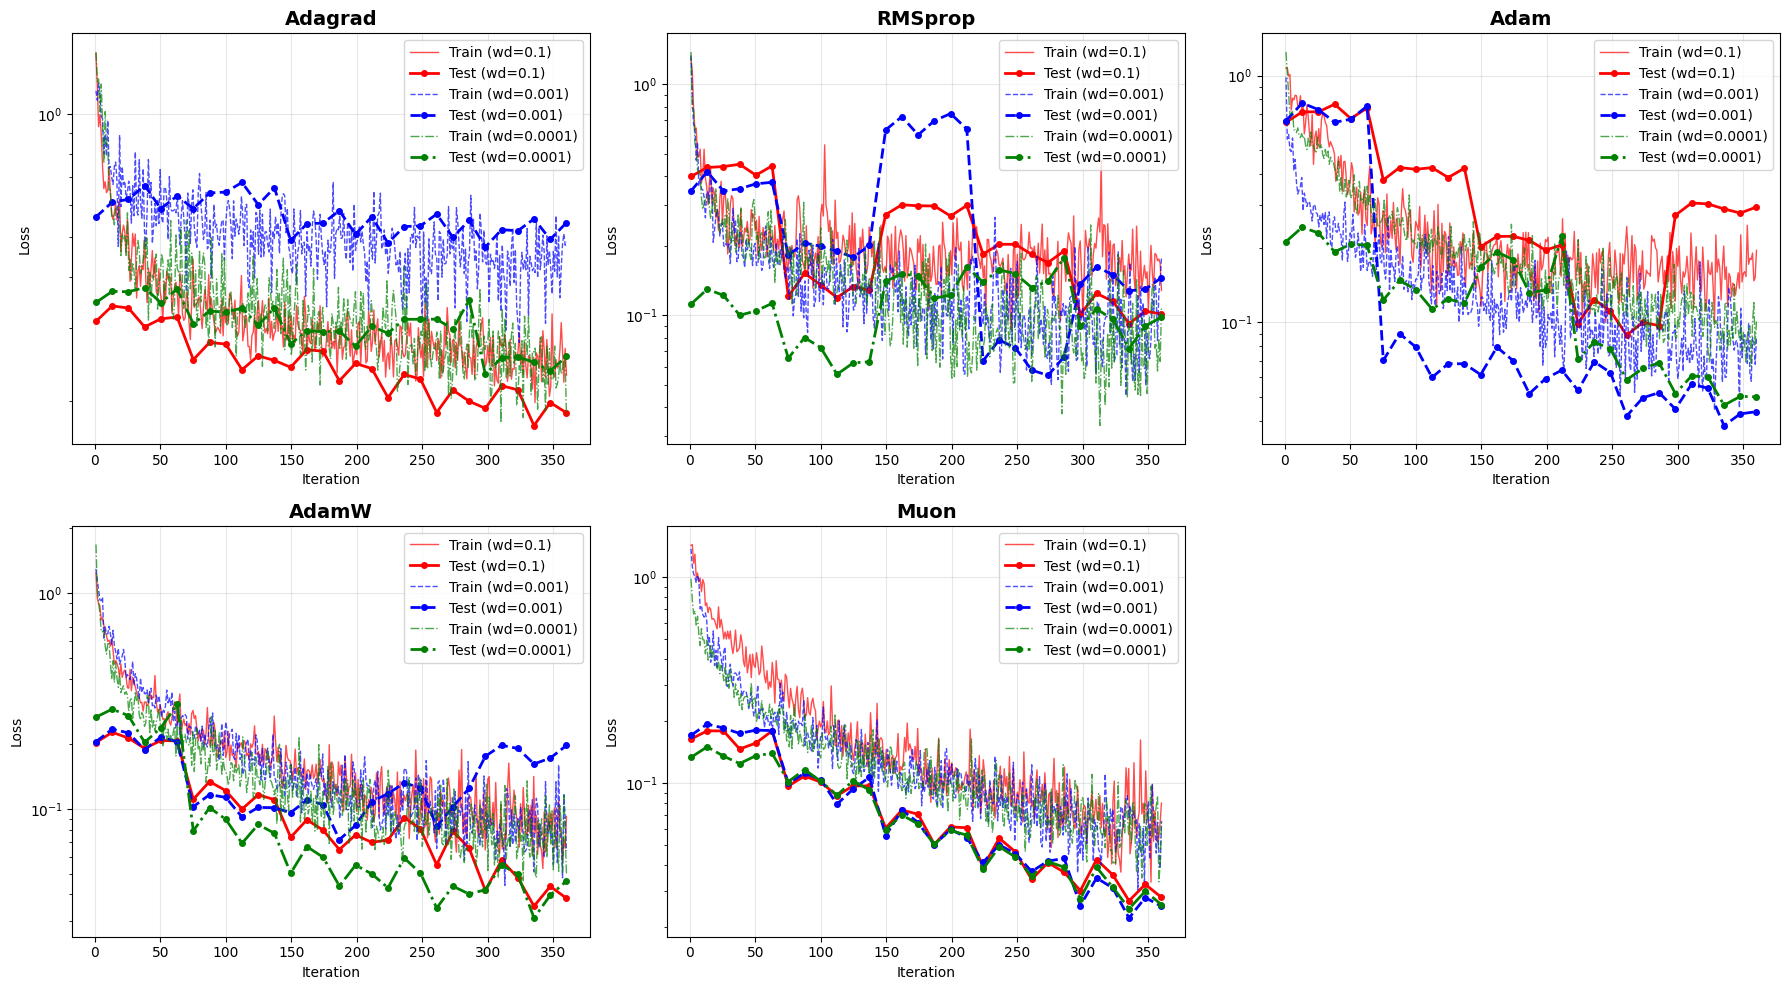

In [55]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, (opt_name, opt_data) in enumerate(results.items()):
    ax = axes[i]

    for j, (wd, color, ls) in enumerate(zip(weight_decays, colors, line_styles)):
        train_losses = opt_data[wd]['train_losses']
        test_losses = opt_data[wd]['test_losses']

        train_iterations = range(1, len(train_losses) + 1)
        ax.plot(train_iterations, train_losses,
                color=color, linestyle=ls, linewidth=1, alpha=0.7,
                label=f'Train (wd={wd})')

        test_epochs = np.linspace(1, len(train_losses), len(test_losses))
        ax.plot(test_epochs, test_losses,
                color=color, linestyle=ls, linewidth=2,
                label=f'Test (wd={wd})', marker='o', markersize=4)

    ax.set_title(f'{opt_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

for i in range(len(optimizers_config), 6):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Сравните оптимизаторы с помощью инференса на 3 случайных сэмплах из тестового датасета. Вам нужно загрузить предобученные модели и визуализировать сравнение зашумленного и очищенного аудио.

In [37]:
optimizers_to_evaluate = ['Adagrad_wd_0.001', 'RMSprop_wd_0.1', 'Adam_wd_0.1', 'AdamW_wd_0.001', 'Muon_wd_0.1']
models = {}

# Загружаем сохраненные модели
print("Загрузка моделей...")
for opt_name in optimizers_to_evaluate:
    model = UNetSpectrogramDenoiser().to(device)
    model.load_state_dict(torch.load(f'models/{opt_name}_denoiser.pt')[opt_name])
    model.eval()
    models[opt_name] = model
print("Модели успешно загружены.")

# Выбираем 3 случайных сэмпла из тестового датасета
random_indices = random.sample(range(len(test_ds)), 3)

print("\nЗапуск инференса на 3 случайных сэмплах...")
for i, idx in enumerate(random_indices):
    noisy_mag, clean_mag, noisy_wav, clean_wav = test_ds[idx]

    print("\nЗашумленный сигнал:")
    display(Audio(noisy_wav.numpy(), rate=44100))

    print("\nЧистый сигнал:")
    display(Audio(clean_wav.numpy(), rate=44100))

    # Добавляем размерность батча
    noisy_mag_batch = noisy_mag.unsqueeze(0).to(device)

    print(f"\n--- Сэмпл #{i+1} ---")

    fig = plt.figure(figsize=(15, 6 + 2 * len(models)))
    gs = fig.add_gridspec(2 + len(models), 2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title("Зашумленное аудио")
    ax1.plot(noisy_wav.numpy())

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title("Очищенное аудио")
    ax2.plot(clean_wav.numpy())

    ax3 = fig.add_subplot(gs[1, 0])
    ax3.set_title("Зашумленная спектрограмма")
    ax3.imshow(noisy_mag.numpy(), aspect='auto', origin='lower')

    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_title("Очищенная спектрограмма")
    ax4.imshow(clean_mag.numpy(), aspect='auto', origin='lower')

    row = 2
    for opt_name, model in models.items():
        with torch.no_grad():
            # Получаем предсказанную спектрограмму
            pred_mag_batch = model(noisy_mag_batch)

            # Извлекаем фазу и восстанавливаем аудио
            phase, noisy_chunk = extract_phase_and_chunk(
                noisy_wav.unsqueeze(0),
                pred_mag_batch.shape[1:],
                n_fft=512, hop_length=128,
                device=device
            )
            enhanced_wav_batch = istft_from_mag_phase(
                pred_mag_batch.squeeze(0), phase,
                n_fft=512, hop_length=128,
                length=noisy_chunk.shape[1]
            )
            enhanced_wav = enhanced_wav_batch.cpu().squeeze(0).numpy()
            print(f"\nОчищенный сигнал {opt_name}:")
            display(Audio(enhanced_wav, rate=44100))

            # Визуализация результата шумоподавления
            ax = fig.add_subplot(gs[row, :])
            ax.set_title(f"Результат шумоподавления с помощью {opt_name}")
            ax.plot(enhanced_wav)
            row += 1

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Дополнительная часть (10 баллов)

__Задача 2.__ Сложность достижения быстрой сходимости и качественных решений во многом зависит от выбранной скорости обучения. Приложения с большим количеством агентов, каждый из которых имеет свой оптимизатор, усложняют настройку скорости обучения. Некоторые оптимизаторы, настраиваемые вручную, показывают хорошие результаты, но эти методы обычно требуют квалификации специалистов и трудоемкой работы. Поэтому в последние годы для оптимизации без изменения скорости обучения стали популярны "беспараметрические" методы адаптивной скорости обучения (_parameter-free methods_). В этой задаче мы познакомимся с основными из них.

__a) (2.5 балла)__ Первый метод, который будет предложен к рассмотрению — Distance over Gradients (`DoG`). Он был впервые предложен в статье ["DoG is SGD's Best Friend: A Parameter-Free Dynamic Step Size Schedule"](https://arxiv.org/pdf/2302.12022). Основная идея — основываясь на методе `AdaGrad` найти способ адаптивно искать параметр шага $D$. Оценка на $D$ зависит от начальной точки $x^0$ и точки глобального минимума $x^*$. Если мы будем считать, что наш алгоритм сходится к оптимуму, то можно считать расстояние на $k$-ом шаге:

$$
\| x^k - x^0 \|_2 \to \| x^* - x^0 \|_2.
$$

Отсюда, обозначив в качестве $d_k$ оценку на $D$ на $k$-ом шаге, мы можем оценить шаг на $k$-ом шаге:

$$
\gamma_k = \frac{d_k}{\sqrt{\sum \limits_{t = 1}^k \| g^t \|^2 + \varepsilon}} = \frac{\max \limits_{t \in \overline{1, k}}\| x^0 - x^t\|_2}{\sqrt{\sum \limits_{t = 1}^k \| g^t \|^2 + \varepsilon}}.
$$

Однако пока непонятно, почему метод называется `DoG`. Заметим, что $d_k$ может быть записано как

$$
d_k = \max \limits_{t \in \overline{1, k - 1}} \left\| \sum \limits_{\tau = 0}^t \gamma_{\tau} \nabla f(x^\tau) \right\|_2.
$$

_Замечание: $d_k$ можно пересчитать следующим образом: $d_k = \max (d_{k - 1}, \|x^k - x^0\|_2)$._

In [38]:
class DoG(Optimizer):
    """
    Реализация оптимизатора DoG.

    Параметры:
        params (Iterable): Итерируемый объект параметров для оптимизации или словарь
        d_0 (float): Начальный шаг
        weight_decay (float): Коэффициент L2-регуляризации
    """

    def __init__(self, params, d_0=1e-5, weight_decay=0):
        defaults = dict(d_0=d_0, weight_decay=weight_decay)
        super(DoG, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        """
        Выполняет один шаг оптимизатора.

        Параметры:
            closure (Сallable): Замыкание, которое пересчитывает модель и возвращает loss

        Возвращает:
            loss (float): Значение функции потерь
        """
        loss = closure() if closure is not None else None

        for group in self.param_groups:
            d_0 = group['d_0']
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data

                if weight_decay != 0:
                    grad = grad.add(p.data, alpha=weight_decay)

                state = self.state[p]
                if 'step' not in state:
                    state['step'] = 0
                    state['grad_norm_sum'] = torch.zeros_like(p.data)
                    state['x0'] = p.data.clone()
                    state['d_k'] = torch.zeros_like(p.data)

                state['step'] += 1

                state['grad_norm_sum'].add_(grad.pow(2))

                current_distance = (p.data - state['x0']).abs()
                state['d_k'] = torch.max(state['d_k'], current_distance)

                step_size = state['d_k'] / (state['grad_norm_sum'].sqrt() + 1e-8)

                p.data.add_(grad * step_size, alpha=-1)

        return loss

Проверьте работу:

In [41]:
train_losses_dog, test_losses_dog, test_snr_dog, test_si_sdr_dog, model = trainer(
    num_epochs=1,
    batch_size=16,
    model_class=UNetSpectrogramDenoiser,
    criterion=torch.nn.MSELoss(),
    optimizer_class=DoG,
    optimizer_params={'weight_decay': 0},
    train_loader=train_loader,
    test_loader=test_loader,
    save_models=False,
    optimizer_name='DoG',
    test=True
)

Эпоха 1/1 | Время: 00:08 | Потери (обучение): 0.0172 | Потери (тест): 0.2141 | SNR: -0.14 дБ | SI-SDR: -2.82 дБ


__б) (2.5 балла)__ Рассмотрим метод [`COCOB`](https://arxiv.org/pdf/1705.07795). Он основан на схеме ставок на монету, когда на каждой итерации ставится определенная сумма денег на исход подбрасывания монеты таким образом, чтобы максимизировать общее богатство, находящееся в распоряжении. Франческо Орабона применяет ту же идею к оптимизации функции, где ставка соответствует размеру шага, сделанного вдоль оси независимой переменной. Общее богатство и результат броска монеты соответствуют точке оптимума функции и отрицательному субградиенту функции в точке ставки, соответственно. В каждом раунде ставится часть текущего общего богатства (точка оптимума). Стратегия ставок разработана таким образом, что общее богатство не становится отрицательным ни в одной точке, а доля поставленных денег в каждом раунде увеличивается до тех пор, пока исход броска монеты не станет постоянным.

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^0 \in \mathbb{R}^d$
- Начальный буфер $L^{-1} = 0 \in \mathbb{R}^d$
- Начальный буфер $G_{-1} = 0 \in \mathbb{R}^d$
- Начальный буфер $\theta^{-1} = 0 \in \mathbb{R}^d$
- Начальный буфер $R^{-1} = 0 \in \mathbb{R}^d$
- Константа прогрева $\alpha \geq 0$
- Коэффициент $L_2$-регуляризации $\lambda \geq 0$

---

$k$_-ая итерация_:

1. Добавить регуляризационный член к градиенту:

$$
g^k = \nabla f \left(x^k\right) + \lambda x
$$

2. Обновить максимум абсолютных градиентов по координатам:

$$
L^k = \max \left(L^{k-1}, \left|g^k\right|\right)
$$

3. Обновить сумму модулей градиента:

$$
G^k = G^{k-1} + \left|g^k\right|
$$

4. Накопить знакованный градиент:

$$
\theta^k = \theta^{k - 1} - g^k
$$

5. Обновить богатство, не давая ему уйти в минус:

$$
R^k = \max \left(R^{k - 1} - g^k \left(x^k - x^0\right), 0\right)
$$

5. Сделать шаг алгоритма:

$$
x^{k + 1} = x^0 + \frac{L^k (R^k + L^k)}{\max \left(G^k, \alpha L^k \right) L^k} \operatorname{sign} \left(\theta^k\right)
$$

In [42]:
class COCOB(Optimizer):
    """
    Реализация оптимизатора COCOB.

    Параметры:
        params (Iterable): Итерируемый объект параметров для оптимизации или словарь
        d_0 (float): Начальный шаг
        alpha (float): Определяет количество итераций прогрева
        weight_decay (float): Коэффициент L2-регуляризации
    """

    def __init__(self, params, alpha=100, weight_decay=1e-2):
        defaults = dict(alpha=alpha, weight_decay=weight_decay)
        super(COCOB, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        """
        Выполняет один шаг оптимизатора.

        Параметры:
            closure (Сallable): Замыкание, которое пересчитывает модель и возвращает loss

        Возвращает:
            loss (float): Значение функции потерь
        """
        loss = closure() if closure is not None else None

        for group in self.param_groups:
            alpha = group['alpha']
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]

                if len(state) == 0:
                    state['L'] = torch.zeros_like(p.data)
                    state['G'] = torch.zeros_like(p.data)
                    state['theta'] = torch.zeros_like(p.data)
                    state['R'] = torch.zeros_like(p.data)
                    state['x0'] = torch.clone(p.data).detach()

                grad = p.grad.data
                if weight_decay != 0:
                    grad = grad.add(p.data, alpha=weight_decay)

                state['L'] = torch.max(state['L'], torch.abs(grad))
                state['G'] = state['G'] + torch.abs(grad)
                state['theta'] = state['theta'] - grad
                wealth_update = state['R'] - grad * (p.data - state['x0'])
                state['R'] = torch.max(wealth_update, torch.zeros_like(wealth_update))

                denominator = torch.max(state['G'], alpha * state['L'])

                step_ratio = state['L'] * (state['R'] + state['L']) / (denominator * state['L'] + 1e-8)

                p.data.copy_(state['x0'] + step_ratio * torch.sign(state['theta']))
        return loss

Проверьте работу:

In [43]:
train_losses_cocob, test_losses_cocob, test_snr_cocob, test_si_sdr_cocob, model = trainer(
    num_epochs=1,
    batch_size=16,
    model_class=UNetSpectrogramDenoiser,
    criterion=torch.nn.MSELoss(),
    optimizer_class=COCOB,
    optimizer_params={'weight_decay': 1e-2},
    train_loader=train_loader,
    test_loader=test_loader,
    save_models=False,
    optimizer_name='COCOB',
    test=True
)

Эпоха 1/1 | Время: 00:07 | Потери (обучение): 0.0225 | Потери (тест): 0.2280 | SNR: -0.17 дБ | SI-SDR: -2.26 дБ


__в) (2.5 балла)__ Еще одним _paramter-free_ методом будет `Prodigy`, представленный в работе [Prodigy: An Expeditiously Adaptive Parameter-Free Learner](https://arxiv.org/pdf/2306.06101).

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^0 \in \mathbb{R}^d$
- Начальный буфер $v^{-1} = 0 \in \mathbb{R}^d$
- Начальный буфер $G^{-1} = 0 \in \mathbb{R}^d$
- Начальный буфер $r^{-1} = 0 \in \mathbb{R}$
- Начальный буфер $s^{-1} = 0 \in \mathbb{R}^d$
- Начальный шаг $d_0 \geq 0$
- Коэффициент сглаживания градиентов $\beta_1 \geq 0$
- Коэффициент сглаживания квадратов градиентов $\beta_2 \geq 0$
- Коэффициент $L_2$-регуляризации $\lambda \geq 0$

---


$k$_-ая итерация_:

1. Добавить регуляризационный член к градиенту:

$$
g^k = \nabla f \left(x^k\right) + \lambda x
$$

2. Обновить сумму градиентов:

$$
v^{k + 1} = \beta_1 v^k + (1 - \beta_1) d_k g^k
$$

3. Обновить сумму градиентов:

$$
G^{k + 1} = \beta_2 G^k + (1 - \beta_2) d_k^2 \left(g^k\right)^2
$$

4. Обновить богатство:

$$
r^{k + 1} = \sqrt{\beta_2} r^k + (1 - \sqrt{\beta_2}) d_k^2 \langle g^k, x^0 - x^k \rangle
$$

5. Обновить накопленные направления:

$$
s^{k + 1} = \sqrt{\beta_2} s^k + (1 - \sqrt{\beta_2}) d_k^2 g^k
$$

6. Вычислить кандидата на новый масштаб шага:

$$
\hat{d}_{k + 1} = \frac{r^{k + 1}}{\|s^{k + 1}\|_1}
$$

7. Обновить масштаб шага:

$$
d_{k + 1} = \max(d_k, \hat{d}_{k + 1})
$$

8. Выполнить шаг обновления параметров:

$$
x^{k + 1} = x^k - d_k \frac{v^{k + 1}}{\sqrt{G^{k + 1}} + d_k \varepsilon}
$$

In [47]:
class Prodigy(Optimizer):
    """
    Реализация оптимизатора Prodigy.

    Параметры:
        params (Iterable): Итерируемый объект параметров для оптимизации или словарь
        betas (tuple): Параметры сглаживания
        d_0 (float): Начальный шаг
        weight_decay (float): Коэффициент L2-регуляризации
    """

    def __init__(self, params, betas=(0.9, 0.999), d_0=1e-4, weight_decay=0):
        defaults = dict(betas=betas, d_0=d_0, weight_decay=weight_decay)
        super(Prodigy, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        """
        Выполняет один шаг оптимизатора.

        Параметры:
            closure (Сallable): Замыкание, которое пересчитывает модель и возвращает loss

        Возвращает:
            loss (float): Значение функции потерь
        """
        loss = closure() if closure is not None else None

        for group in self.param_groups:
            beta1, beta2 = group['betas']
            d_0 = group['d_0']
            weight_decay = group['weight_decay']
            sqrt_beta2 = beta2 ** 0.5

            for p in group['params']:
                if p.grad is None:
                    continue



        return loss

Проверьте работу:

In [48]:
train_losses_prodigy, test_losses_prodigy, test_snr_prodigy, test_si_sdr_prodigy, model = trainer(
    num_epochs=1,
    batch_size=16,
    model_class=UNetSpectrogramDenoiser,
    criterion=torch.nn.MSELoss(),
    optimizer_class=Prodigy,
    optimizer_params={'weight_decay': 1e-2},
    train_loader=train_loader,
    test_loader=test_loader,
    save_models=False,
    optimizer_name='Prodigy',
    test=True
)

Эпоха 1/1 | Время: 00:08 | Потери (обучение): 0.0168 | Потери (тест): 0.2073 | SNR: -0.12 дБ | SI-SDR: -2.78 дБ


__г) (2.5 балл)__ Теперь пришло время обучения. Сравните данные оптимизаторы с `Adam`. Число эпох поставьте равным 5.

In [51]:
optimizers_config_pf = {
    'Adam': {'lr': 1e-3, 'weight_decay': 1e-3},
    'COCOB': {'alpha': 100, 'weight_decay': 1e-2},
    'DoG': {'d_0': 1e-5, 'weight_decay': 0},
}

results_pf = {}

for opt_name, params in optimizers_config_pf.items():
    print(f"\n=== Обучение {opt_name} ===\n")

    if opt_name == 'Adam':
        opt_class = Adam
    elif opt_name == 'COCOB':
        opt_class = COCOB
    elif opt_name == 'DoG':
        opt_class = DoG

    train_losses, test_losses, test_snr, test_si_sdr, model = trainer(
        num_epochs=5,
        batch_size=32,
        model_class=UNetSpectrogramDenoiser,
        criterion=torch.nn.MSELoss(),
        optimizer_class=opt_class,
        optimizer_params=params,
        train_loader=train_loader,
        test_loader=test_loader,
        save_models=True,
        optimizer_name=opt_name,
        test=False
    )

    results_pf[opt_name] = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'test_snr': test_snr,
        'test_si_sdr': test_si_sdr
    }


=== Обучение Adam ===



Эпоха 1/5 | Время: 00:49 | Потери (обучение): 0.2996 | Потери (тест): 0.1432 | SNR: 8.96 дБ | SI-SDR: 8.41 дБ


Эпоха 2/5 | Время: 00:47 | Потери (обучение): 0.1455 | Потери (тест): 0.0744 | SNR: 11.31 дБ | SI-SDR: 10.98 дБ


Эпоха 3/5 | Время: 00:48 | Потери (обучение): 0.1099 | Потери (тест): 0.1146 | SNR: 9.68 дБ | SI-SDR: 9.73 дБ


Эпоха 4/5 | Время: 00:48 | Потери (обучение): 0.0901 | Потери (тест): 0.0597 | SNR: 11.91 дБ | SI-SDR: 12.64 дБ


Эпоха 5/5 | Время: 00:48 | Потери (обучение): 0.0801 | Потери (тест): 0.0366 | SNR: 13.43 дБ | SI-SDR: 13.24 дБ
Модель Adam сохранена в models/Adam_denoiser.pt

=== Обучение COCOB ===



Эпоха 1/5 | Время: 00:48 | Потери (обучение): 0.3137 | Потери (тест): 0.2102 | SNR: 7.46 дБ | SI-SDR: 6.60 дБ


Эпоха 2/5 | Время: 00:48 | Потери (обучение): 0.2517 | Потери (тест): 0.2004 | SNR: 7.82 дБ | SI-SDR: 7.04 дБ


Эпоха 3/5 | Время: 00:48 | Потери (обучение): 0.2397 | Потери (тест): 0.1530 | SNR: 8.79 дБ | SI-SDR: 8.37 дБ


Эпоха 4/5 | Время: 00:48 | Потери (обучение): 0.2303 | Потери (тест): 0.1753 | SNR: 8.24 дБ | SI-SDR: 7.55 дБ


Эпоха 5/5 | Время: 00:49 | Потери (обучение): 0.2253 | Потери (тест): 0.1842 | SNR: 8.00 дБ | SI-SDR: 7.28 дБ
Модель COCOB сохранена в models/COCOB_denoiser.pt

=== Обучение DoG ===



Эпоха 1/5 | Время: 00:48 | Потери (обучение): 1.1599 | Потери (тест): 1.3711 | SNR: -0.64 дБ | SI-SDR: -20.96 дБ


Эпоха 2/5 | Время: 00:48 | Потери (обучение): 1.1581 | Потери (тест): 1.3715 | SNR: -0.64 дБ | SI-SDR: -20.99 дБ


Эпоха 3/5 | Время: 00:48 | Потери (обучение): 1.1640 | Потери (тест): 1.3709 | SNR: -0.64 дБ | SI-SDR: -20.94 дБ


Эпоха 4/5 | Время: 00:47 | Потери (обучение): 1.1561 | Потери (тест): 1.3713 | SNR: -0.64 дБ | SI-SDR: -20.98 дБ


Эпоха 5/5 | Время: 00:48 | Потери (обучение): 1.1635 | Потери (тест): 1.3707 | SNR: -0.64 дБ | SI-SDR: -20.95 дБ
Модель DoG сохранена в models/DoG_denoiser.pt


Постройте графики всех полученных метрик. Что можно сказать о сходимости методов?

Сравните оптимизаторы с помощью инференса на 3 случайных сэмплах из тестового датасета. Вам нужно загрузить предобученные модели и визуализировать сравнение зашумленного и очищенного аудио.

In [52]:
optimizers_to_evaluate = ['Adam', 'COCOB', 'DoG']
models = {}

# Загружаем сохраненные модели
print("Загрузка моделей...")
for opt_name in optimizers_to_evaluate:
    model = UNetSpectrogramDenoiser().to(device)
    model.load_state_dict(torch.load(f'models/{opt_name}_denoiser.pt')[opt_name])
    model.eval()
    models[opt_name] = model
print("Модели успешно загружены.")

# Выбираем 3 случайных сэмпла из тестового датасета
random_indices = random.sample(range(len(test_ds)), 3)

print("\nЗапуск инференса на 3 случайных сэмплах...")
for i, idx in enumerate(random_indices):
    noisy_mag, clean_mag, noisy_wav, clean_wav = test_ds[idx]

    print("\nЗашумленный сигнал:")
    display(Audio(noisy_wav.numpy(), rate=44100))

    print("\nЧистый сигнал:")
    display(Audio(clean_wav.numpy(), rate=44100))

    # Добавляем размерность батча
    noisy_mag_batch = noisy_mag.unsqueeze(0).to(device)

    print(f"\n--- Сэмпл #{i+1} ---")

    fig = plt.figure(figsize=(15, 6 + 2 * len(models)))
    gs = fig.add_gridspec(2 + len(models), 2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title("Зашумленное аудио")
    ax1.plot(noisy_wav.numpy())

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title("Очищенное аудио")
    ax2.plot(clean_wav.numpy())

    ax3 = fig.add_subplot(gs[1, 0])
    ax3.set_title("Зашумленная спектрограмма")
    ax3.imshow(noisy_mag.numpy(), aspect='auto', origin='lower')

    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_title("Очищенная спектрограмма")
    ax4.imshow(clean_mag.numpy(), aspect='auto', origin='lower')

    row = 2
    for opt_name, model in models.items():
        with torch.no_grad():
            # Получаем предсказанную спектрограмму
            pred_mag_batch = model(noisy_mag_batch)

            # Извлекаем фазу и восстанавливаем аудио
            phase, noisy_chunk = extract_phase_and_chunk(
                noisy_wav.unsqueeze(0),
                pred_mag_batch.shape[1:],
                n_fft=512, hop_length=128,
                device=device
            )
            enhanced_wav_batch = istft_from_mag_phase(
                pred_mag_batch.squeeze(0), phase,
                n_fft=512, hop_length=128,
                length=noisy_chunk.shape[1]
            )
            enhanced_wav = enhanced_wav_batch.cpu().squeeze(0).numpy()
            print(f"\nОчищенный сигнал {opt_name}:")
            display(Audio(enhanced_wav, rate=44100))

            # Визуализация результата шумоподавления
            ax = fig.add_subplot(gs[row, :])
            ax.set_title(f"Результат шумоподавления с помощью {opt_name}")
            ax.plot(enhanced_wav)
            row += 1

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.